## Bank Loan Prediction

This is a classification predictive analytics project. Here, I will be using Artificial Neural Network to build a model that predicts whether a customer has bank loan or not.  

### Importing Libraries, Dataset, and EDA

In [171]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler

# suppressing warnings
import warnings
warnings.filterwarnings('ignore')

In [172]:
#importing dataset
df = pd.read_csv('UniversalBank.csv')

In [173]:
df

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,0,1,0


In [174]:
#dropping unnecessary columns
df.drop('ID',axis=1, inplace=True)

In [175]:
df.dtypes

Age                     int64
Experience              int64
Income                  int64
ZIP Code                int64
Family                  int64
CCAvg                 float64
Education               int64
Mortgage                int64
Personal Loan           int64
Securities Account      int64
CD Account              int64
Online                  int64
CreditCard              int64
dtype: object

In [176]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,5000.0,45.338400,11.463166,23.0,35.0,45.0,55.0,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.0,20.0,30.0,43.0
Income,5000.0,73.774200,46.033729,8.0,39.0,64.0,98.0,224.0
ZIP Code,5000.0,93152.503000,2121.852197,9307.0,91911.0,93437.0,94608.0,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.0,2.0,3.0,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.7,1.5,2.5,10.0
Education,5000.0,1.881000,0.839869,1.0,1.0,2.0,3.0,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.0,0.0,101.0,635.0
Personal Loan,5000.0,0.096000,0.294621,0.0,0.0,0.0,0.0,1.0
Securities Account,5000.0,0.104400,0.305809,0.0,0.0,0.0,0.0,1.0


In [177]:
#defining numerical and categorical variables
categorical_var = ['ZIP Code','Education','Securities Account', 'CD Account', 'Online', 'CreditCard']
target_var = ['Personal Loan']
numerical_var = set(df.columns)-set(categorical_var)-set(target_var)
numerical_var

{'Age', 'CCAvg', 'Experience', 'Family', 'Income', 'Mortgage'}

In [178]:
#Dropping Categorical Variables with Multiple Levels:
high_cardinality = []
for column in categorical_var:
    if len(df[column].value_counts().index)>100:
        high_cardinality.append(column)
high_cardinality

['ZIP Code']

In [179]:
df.drop('ZIP Code',axis=1, inplace=True)
categorical_var= set(categorical_var)-set(['ZIP Code'])

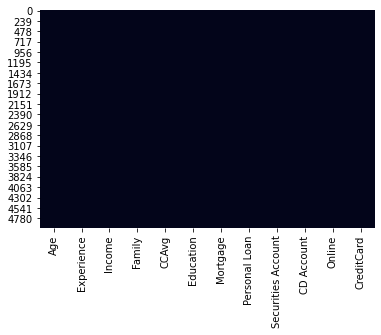

In [180]:
#examining missing values with heatmap
sns.heatmap(df.isnull(),cbar=False)

0    4520
1     480
Name: Personal Loan, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


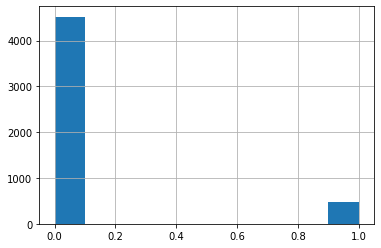

In [181]:
#accessing target variable distribution
print(df['Personal Loan'].value_counts())
print(df['Personal Loan'].hist())

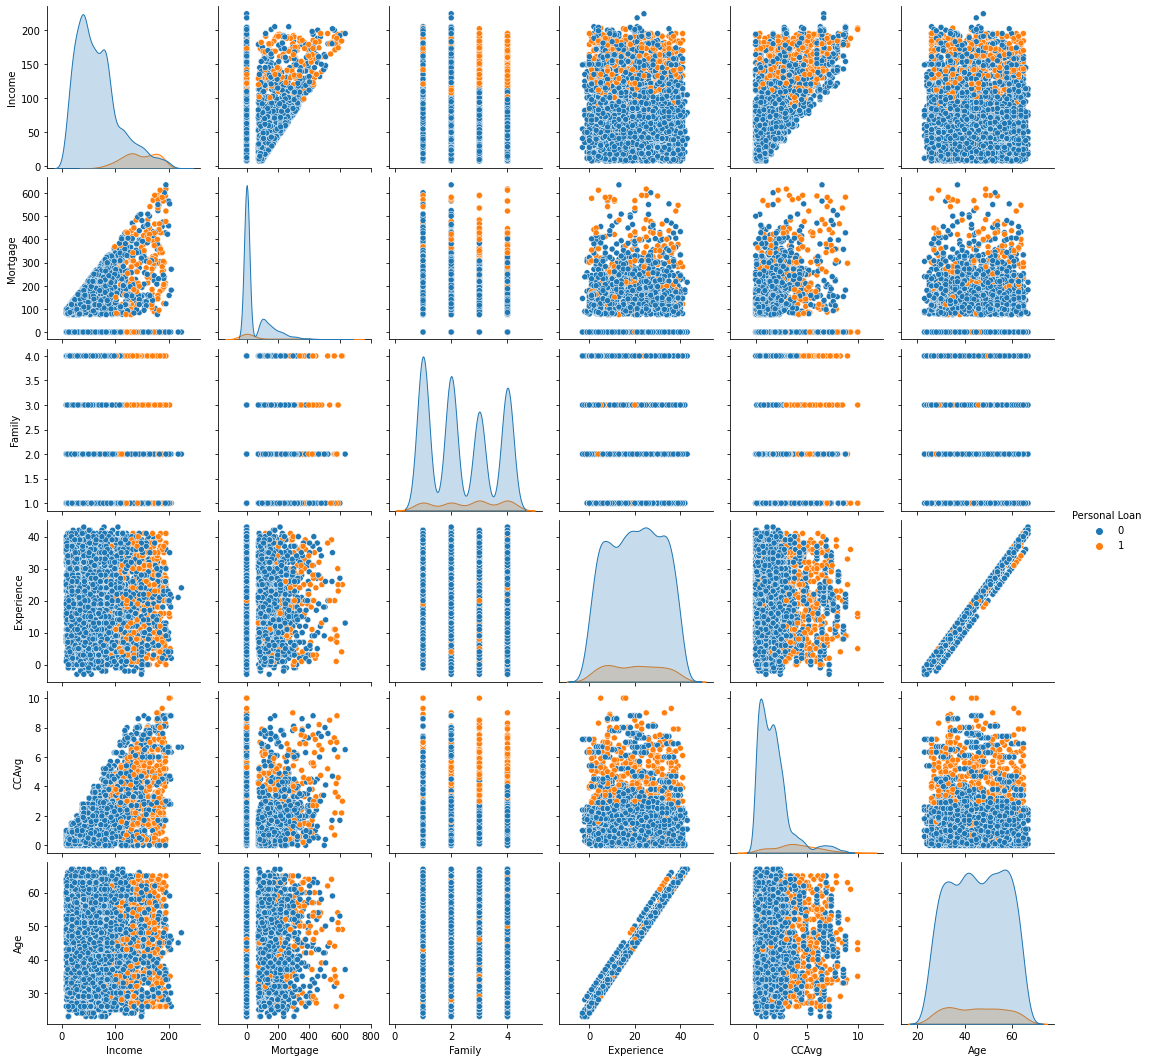

In [182]:
#visualizing numerical variables
sns.pairplot(df[(set(df.columns)-set(categorical_var))],hue='Personal Loan')

In [183]:
df.corr()['Personal Loan'].sort_values(ascending=False)

Personal Loan         1.000000
Income                0.502462
CCAvg                 0.366889
CD Account            0.316355
Mortgage              0.142095
Education             0.136722
Family                0.061367
Securities Account    0.021954
Online                0.006278
CreditCard            0.002802
Experience           -0.007413
Age                  -0.007726
Name: Personal Loan, dtype: float64

### Data Preprocessing

In [184]:
for i in categorical_var:
  print(i)
  print(df[i].value_counts())


Online
1    2984
0    2016
Name: Online, dtype: int64
Securities Account
0    4478
1     522
Name: Securities Account, dtype: int64
CreditCard
0    3530
1    1470
Name: CreditCard, dtype: int64
CD Account
0    4698
1     302
Name: CD Account, dtype: int64
Education
1    2096
3    1501
2    1403
Name: Education, dtype: int64


In [185]:
#Creating dummy variable for Education
edu_dummy_df = pd.get_dummies(df['Education'],drop_first=True)
df.drop(['Education'],axis=1,inplace=True)
df=pd.concat([df,edu_dummy_df],axis = 1)


In [186]:
df.rename(columns={2:"Education_2",3:"Education_3"},inplace=True)

In [187]:
df.columns

Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage',
       'Personal Loan', 'Securities Account', 'CD Account', 'Online',
       'CreditCard', 'Education_2', 'Education_3'],
      dtype='object')

In [191]:
df[['Education_3','Education_2']] = df[['Education_3','Education_2']].astype({'Education_3': 'int64','Education_2':'int64'})

In [192]:
df.dtypes

Age                     int64
Experience              int64
Income                  int64
Family                  int64
CCAvg                 float64
Mortgage                int64
Personal Loan           int64
Securities Account      int64
CD Account              int64
Online                  int64
CreditCard              int64
Education_2             int64
Education_3             int64
dtype: object

In [193]:
#assigning input and target variables
X=df.drop('Personal Loan',axis=1)
y=df['Personal Loan']

In [194]:
#rescaling variables using MinMaxScaler
scaler = MinMaxScaler()

X_ = scaler.fit_transform(X)

X_rescaled = pd.DataFrame(X_,columns=X.columns)

X_rescaled.describe()

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities Account,CD Account,Online,CreditCard,Education_2,Education_3
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.507691,0.502274,0.304510,0.465467,0.193794,0.088974,0.104400,0.06040,0.596800,0.294000,0.280600,0.300200
std,0.260526,0.249303,0.213119,0.382554,0.174766,0.160179,0.305809,0.23825,0.490589,0.455637,0.449337,0.458391
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.272727,0.282609,0.143519,0.000000,0.070000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.500000,0.259259,0.333333,0.150000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000
75%,0.727273,0.717391,0.416667,0.666667,0.250000,0.159055,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


### Artificial Neural Network Model

In [195]:
#splitting data 70/30 into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_rescaled,y,test_size= 0.3,random_state=1)


In [196]:
#developing Artificial Neural Network (ANN)
#we will use 'lgbfs' solver type since it works accurately for smaller data types
MLPC_model = MLPClassifier(hidden_layer_sizes=20,activation='logistic',solver='lbfgs',random_state=1)

MLPC_model.fit(X_train,y_train)

mlpc_y_pred = MLPC_model.predict(X_test)


#### Model Performance Evaluation

In [197]:
#accesssing model performance

##confusion matrix
print(confusion_matrix(y_test,mlpc_y_pred),"\n")

##classification report
print(classification_report(y_test,mlpc_y_pred),"\n")

##roc_auc score
print("ROC AUC Score: ",roc_auc_score(y_test,mlpc_y_pred))

[[1339   12]
 [  25  124]] 

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1351
           1       0.91      0.83      0.87       149

    accuracy                           0.98      1500
   macro avg       0.95      0.91      0.93      1500
weighted avg       0.97      0.98      0.97      1500
 

ROC AUC Score:  0.9116662278501136


#### Identifying Optimal Number of Nodes

In [198]:
from sklearn.model_selection import cross_val_score
min_hidden_layer_size = 5
max_hidden_layer_size = 30
cv_scores = []

for s in range(min_hidden_layer_size,max_hidden_layer_size, 5):
  MLPC_model = MLPClassifier(hidden_layer_sizes=s, activation='logistic',solver='lbfgs', random_state =1)
  scores = cross_val_score(MLPC_model,X_train,y_train.values.ravel(),cv = 5,scoring='accuracy')
  cv_scores.append(scores.mean())

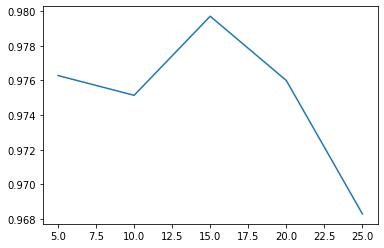

In [199]:
sns.lineplot(x = range(min_hidden_layer_size,max_hidden_layer_size, 5),y=cv_scores)

In [200]:
#determining exact value of k
(cv_scores.index(max(cv_scores))+1)*5             #multiplied by 5 since range is increased by 5

15

The optimal number of nodes based on model accuracy is 15.

#### Rebuilding ANN Model with Optimal Number of Nodes

In [201]:
#accesssing model performance with optimal value of hidden layer size
MLPC_model = MLPClassifier(hidden_layer_sizes=15,activation='logistic',solver='lbfgs',random_state=1)

MLPC_model.fit(X_train,y_train)

mlpc_y_pred = MLPC_model.predict(X_test)
##confusion matrix
print(confusion_matrix(y_test,mlpc_y_pred),"\n")

##classification report
print(classification_report(y_test,mlpc_y_pred),"\n")

##roc_auc score
print("ROC AUC Score: ",roc_auc_score(y_test,mlpc_y_pred))

[[1337   14]
 [  23  126]] 

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1351
           1       0.90      0.85      0.87       149

    accuracy                           0.98      1500
   macro avg       0.94      0.92      0.93      1500
weighted avg       0.97      0.98      0.97      1500
 

ROC AUC Score:  0.9176374447960496


From above ROC AUC score, we can see that once we applied the optimal value of nodes in our ANN model, the model accuracy increased.